In [1]:
import os
import errno
import argparse

import numpy as np
import skimage.io
import skimage.external.tifffile as tiff
import skimage.morphology
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K
from scipy import stats

from deepcell import get_image_sizes
from deepcell import make_training_data
from deepcell import bn_feature_net_31x31
from deepcell import dilated_bn_feature_net_31x31
from deepcell import bn_feature_net_61x61           #model_zoo
from deepcell import dilated_bn_feature_net_61x61


from deepcell import train_model_watershed
from deepcell import train_model_watershed_sample
from deepcell import bn_dense_feature_net
from deepcell import rate_scheduler
from deepcell import train_model_disc, train_model_conv, train_model_sample
from deepcell import run_models_on_directory
from deepcell import export_model
from deepcell import get_data

import accuracy_metrics
from sklearn.metrics import confusion_matrix
from accuracy_metrics import *

# data options
DATA_OUTPUT_MODE = 'sample'
BORDER_MODE = 'valid' if DATA_OUTPUT_MODE == 'sample' else 'same'
RESIZE = True
RESHAPE_SIZE = 2048
N_EPOCHS = 40
WINDOW_SIZE = (15,15)
BATCH_SIZE = 64
MAX_TRAIN = 1e8
BINS = 4

WINDOW_SIZE_CLASS = (15,15)


EDGE_THRESH = 0.25
INT_THRESH = 0.25
CELL_THRESH = 0.25
NUM_FINAL_EROSIONS = 1

INT_ONLY = True
REMAKE_CONV = False

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'
ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else -1



# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'

PREFIX_SEG = 'tissues/mibi/samir'
PREFIX_CLASS = 'tissues/mibi/mibi_full'
PREFIX_SAVE = 'tissues/mibi/pipeline'

FG_BG_DATA_FILE = 'mibi_pipe_wshedFB_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)
CONV_DATA_FILE = 'mibi_watershedconv_{}_{}'.format(K.image_data_format(), 'conv')

CLASS_DATA_FILE = 'mibi_pipe_class_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)

#'2018-07-13_mibi_watershedFB_channels_last_sample_fgbg_0.h5'

#MODEL_FGBG = '2018-08-02_mibi_watershedFB_channels_last_sample_fgbg_0.h5'
#MODEL_FGBG = '2018-07-13_mibi_31x31_channels_last_sample__0.h5'
MODEL_FGBG = '2018-08-20_mibi_31x31_8chanCFHHNPTd__channels_last_sample__0.h5'
CHANNELS_SEG = ['Ca.', 'Fe.', 'H3K27me3', 'H3K9ac', 'Na.', 'P.', 'Ta.', 'dsDNA.']

#single channel?
#MODEL_FGBG = '2018-07-06_mibi_31x31_channels_last_sample__0.h5'

#31x31 classification older
#MODEL_CLASS = '2018-08-09_mibi_balcompare_chan_flysampling_class_channels_last_sample__0.h5'

#61x61 newnoflip
#MODEL_CLASS = '2018-08-13_mibi_61x61_pixelremTWO_R2_class_channels_last_sample__0.h5'

#31x31 no aug
#MODEL_CLASS = '2018-08-11_mibi_31x31_dil2ero2_class_channels_last_sample__0.h5'

#31x31 std lib4
MODEL_CLASS = '2018-08-21_mibi_31x31_r4_rot_med8_normStd_lib4_class_channels_last_sample__0.h5'

RUN_DIR = 'set1'

TRAIN_DIR_SAMPLE = ['set1', 'set2']
TRAIN_DIR_CLASS_RANGE = range(1, 39+1)

NUM_FEATURES_IN_SEG = 2
NUM_FEATURES_OUT_SEG = 3
NUM_FEATURES_CLASS = 17

#CHANNELS_SEG = ['dsDNA', 'Ca', 'H3K27me3', 'H3K9ac', 'Ta']  #Add P?
#CHANNELS_SEG = ['dsDNA']

#CHANNELS_CLASS = ['dsDNA', 'Ca','H3K27me3', 'H3K9ac', 'Ta', 'FoxP3.', 'CD4.', 'CD16.', 'EGFR.', 'CD68.', 'CD8.', 'CD3.',
#                 'Keratin17.', 'CD20.', 'p53.', 'catenin.', 'HLA-DR.', 'CD45.', 'Pan-Keratin.', 'MPO.',
#                 'Keratin6.', 'Vimentin.', 'SMA.', 'CD31.', 'CD56.', 'CD209.', 'CD11c.', 'CD11b.']


## channel lib 4: Leeat classification + trimmed segmentation channels (26)
CHANNELS_CLASS = ['dsDNA', 'Ca', 'Ta', 'FoxP3.', 'CD4.', 'CD16.', 'EGFR.', 'CD68.', 'CD8.', 'CD3.',
                 'Keratin17.', 'CD20.', 'p53.', 'catenin.', 'HLA-DR.', 'CD45.', 'Pan-Keratin.', 'MPO.',
                 'Keratin6.', 'Vimentin.', 'SMA.', 'CD31.', 'CD56.', 'CD209.', 'CD11c.', 'CD11b.']


Using TensorFlow backend.


In [2]:
def dilate(array, mask, num_dilations):
    copy = np.copy(array)
    for x in range(0, num_dilations):
        dilated = skimage.morphology.dilation(copy)

        # if still within the mask range AND one cell not eating another, dilate
        #copy = np.where( ((mask!=0) & (dilated!=copy & copy==0)), dilated, copy)
        copy = np.where( (mask!=0) & (dilated!=copy) & (copy==0), dilated, copy)
    return copy

def dilate_nomask(array, num_dilations):
    copy = np.copy(array)
    for x in range(0, num_dilations):
        dilated = skimage.morphology.dilation(copy)

        # if one cell not eating another, dilate
        #copy = np.where( ((mask!=0) & (dilated!=copy & copy==0)), dilated, copy)
        copy = np.where( (dilated!=copy) & (copy==0), dilated, copy)
    return copy

def erode(array, num_erosions):
    original = np.copy(array)

    for x in range(0, num_erosions):
        eroded = skimage.morphology.erosion(np.copy(original))
        original[original != eroded] = 0

    return original

# runs the sample and watershed

In [3]:
    raw_dir = 'raw'
    data_location = os.path.join(DATA_DIR, PREFIX_CLASS, RUN_DIR, raw_dir)
    output_location = os.path.join(RESULTS_DIR, PREFIX_SEG)
    channel_names = CHANNELS_SEG
    image_size_x, image_size_y = get_image_sizes(data_location, channel_names)


    weights = os.path.join(MODEL_DIR, PREFIX_SEG, MODEL_FGBG)


    n_features = 3
    window_size = (30, 30)

    if DATA_OUTPUT_MODE == 'sample':
        model_fn = dilated_bn_feature_net_31x31                                 #changed to 21x21
    elif DATA_OUTPUT_MODE == 'conv':
        model_fn = bn_dense_feature_net
    else:
        raise ValueError('{} is not a valid training mode for 2D images (yet).'.format(
            DATA_OUTPUT_MODE))

    predictions = run_models_on_directory(
        data_location=data_location,
        channel_names=channel_names,
        output_location=output_location,
        n_features=n_features,
        model_fn=model_fn,
        list_of_weights=[weights],
        image_size_x=image_size_x,
        image_size_y=image_size_y,
        win_x=WINDOW_SIZE[0],
        win_y=WINDOW_SIZE[1],
        split=False)

Using dilated feature net 31x31 with batch normalization
image_normalization2d_1
conv2d_1
batch_normalization_1
activation_1
dilated_max_pool2d_1
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
dilated_max_pool2d_2
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
tensor_prod2d_1
batch_normalization_6
activation_6
tensor_prod2d_2
softmax_1
Processing image 1 of 1


In [24]:
    #0.25 0.25 works good
    edge_thresh = EDGE_THRESH
    interior_thresh = INT_THRESH
    cell_thresh = CELL_THRESH

    print('shape of predictions is:', predictions.shape)

    edge = np.copy(predictions[:,:,:,0])
    edge[edge < edge_thresh] = 0
    edge[edge > edge_thresh] = 1

    interior = np.copy(predictions[:, :, :, 1])
    interior[interior > interior_thresh] = 1
    interior[interior < interior_thresh] = 0

    cell_notcell = 1 - np.copy(predictions[:, :, :, 2])
    cell_notcell[cell_notcell > cell_thresh] = 1
    cell_notcell[cell_notcell < cell_thresh] = 0

    # define foreground as the interior bounded by edge
    fg_thresh = np.logical_and(interior==1, edge==0)

    # remove small objects from the foreground segmentation
    fg_thresh = skimage.morphology.remove_small_objects(fg_thresh, min_size=50, connectivity=1)

    #fg_thresh = skimage.morphology.binary_erosion(fg_thresh)
    #fg_thresh = skimage.morphology.binary_dilation(fg_thresh)

    fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)

    watershed_segmentation = skimage.measure.label(  np.squeeze(fg_thresh), connectivity=2)

    tiff.imsave('/data/results/tissues/mibi/samir/cell_cores.tif', watershed_segmentation)

shape of predictions is: (1, 2018, 2018, 3)


In [11]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20


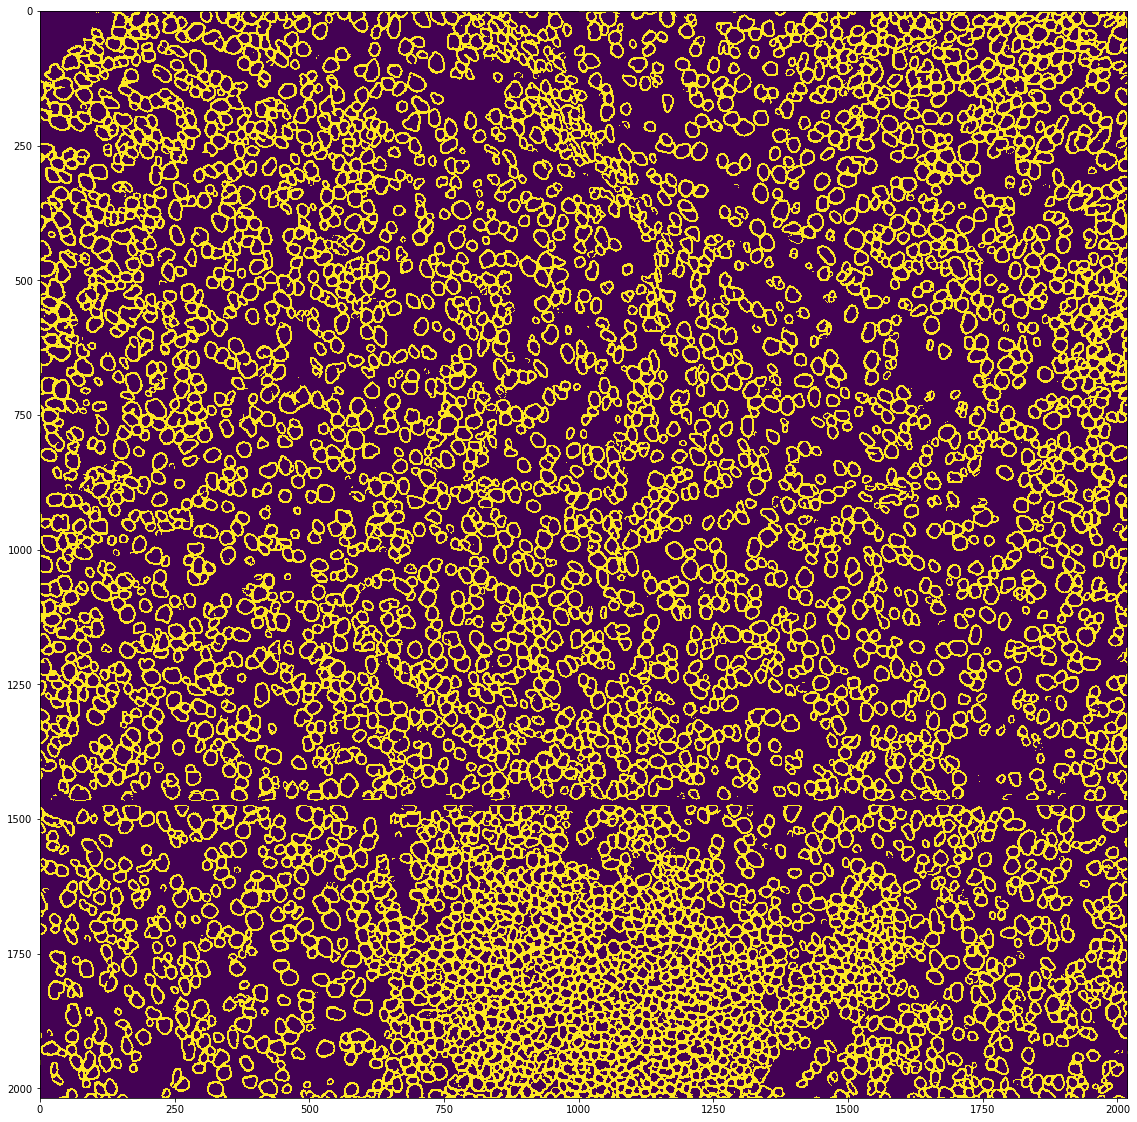

In [12]:
edge = np.squeeze(edge)
plt.imshow(edge)

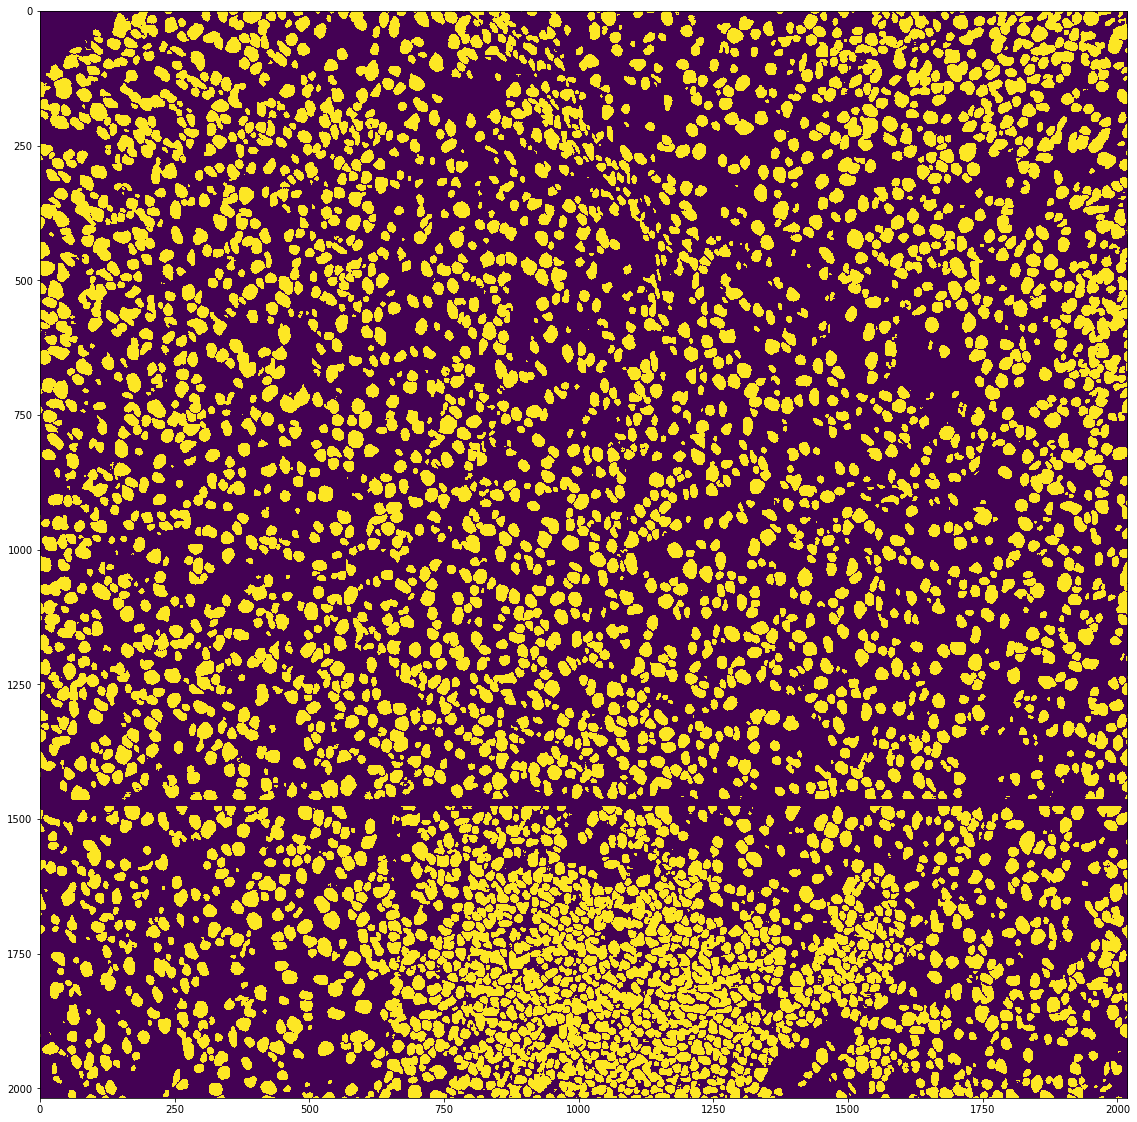

In [14]:
plt.imshow(np.squeeze(interior))

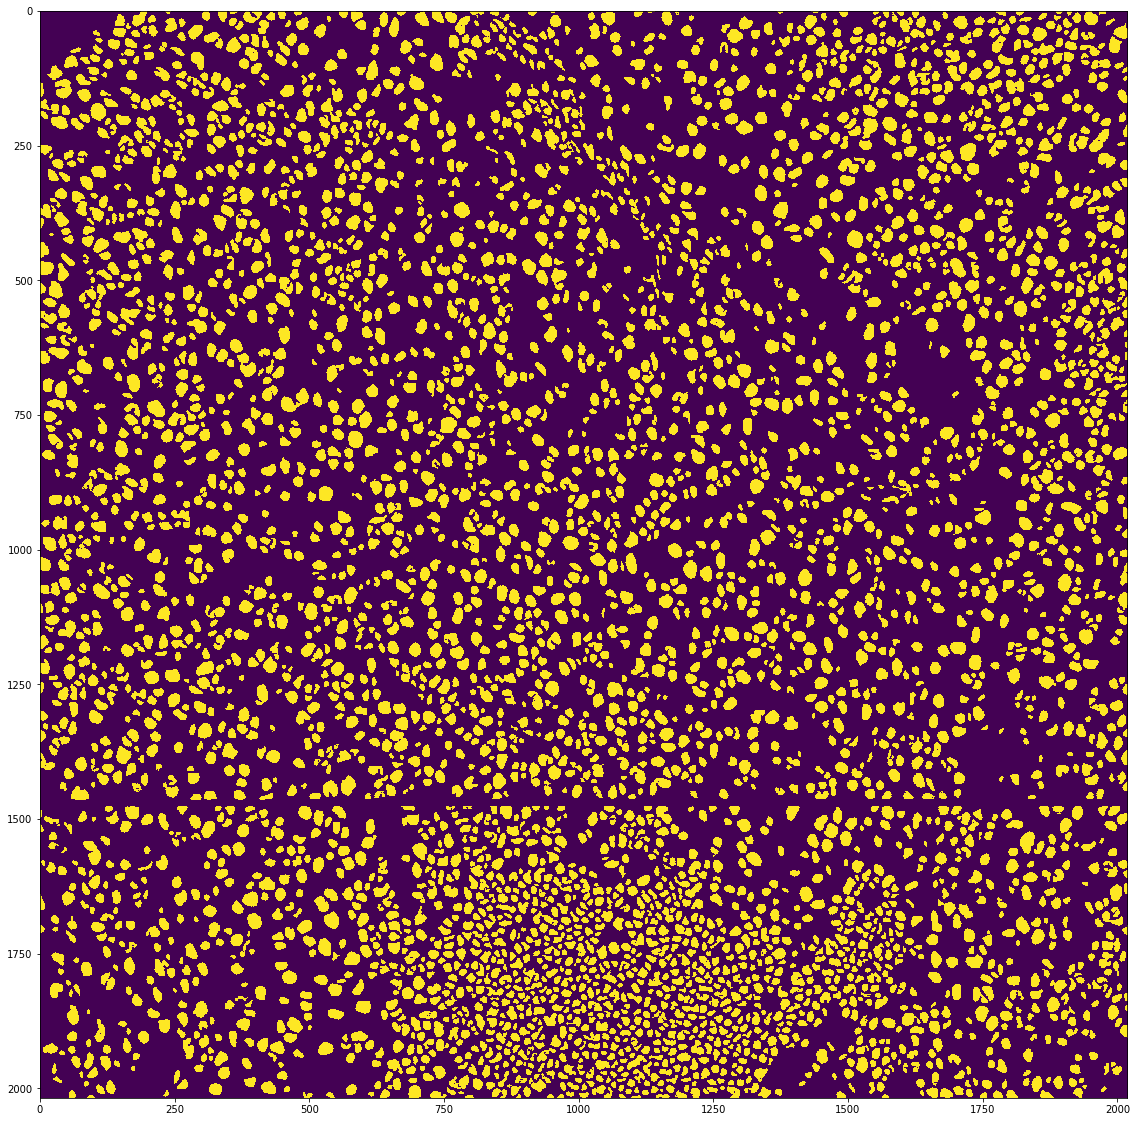

In [15]:
plt.imshow(np.squeeze(fg_thresh))

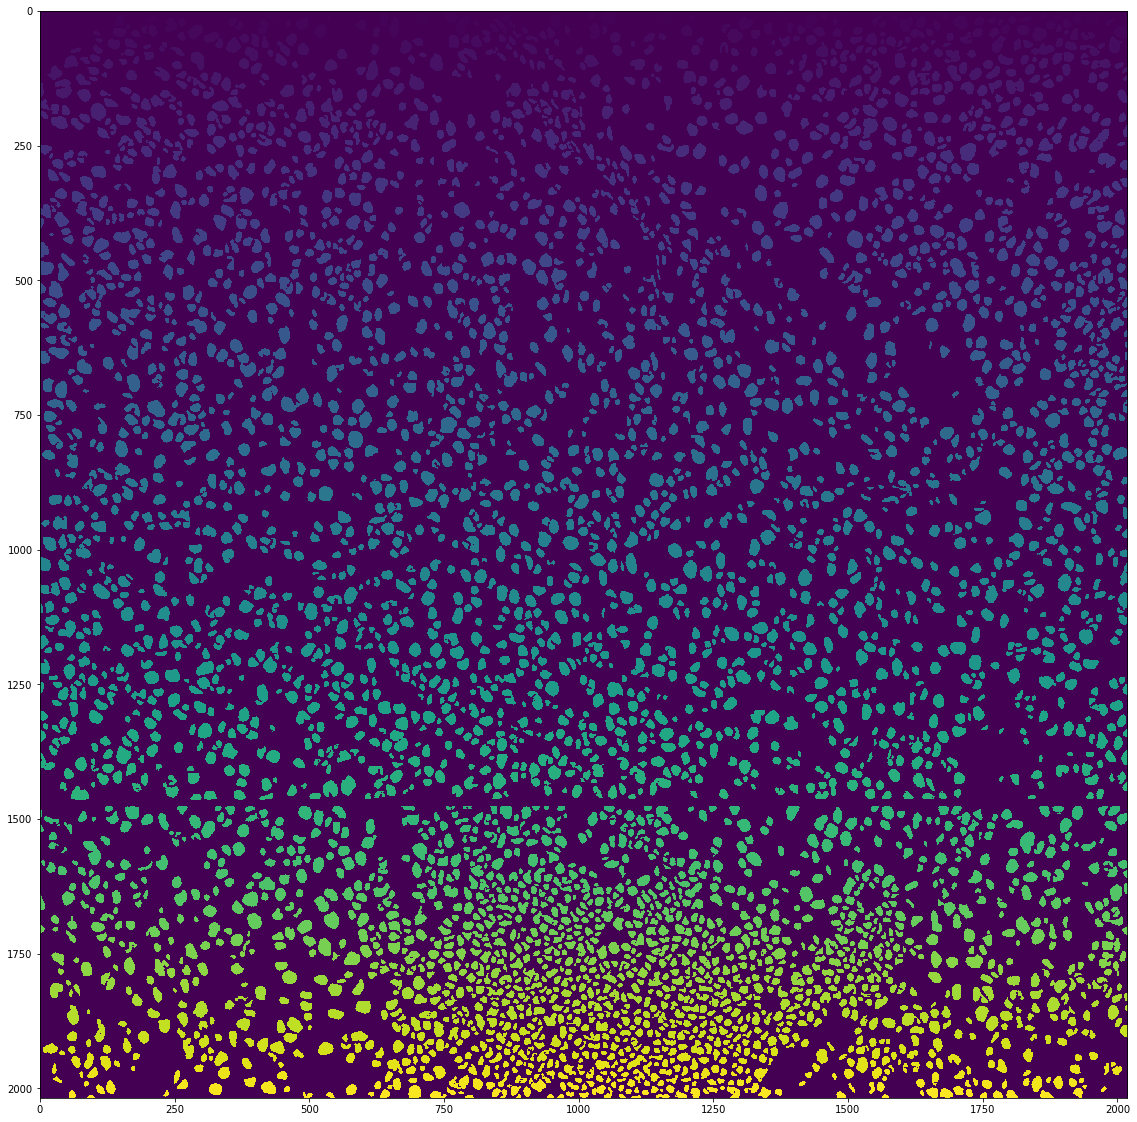

In [16]:
plt.imshow(np.squeeze(watershed_segmentation))

In [25]:
    # dilate gradually into the mask area
    watershed_segmentation = dilate(watershed_segmentation, interior, 2)
    watershed_segmentation = erode(watershed_segmentation, 1)
    watershed_segmentation = dilate(watershed_segmentation, interior, 2)
    watershed_segmentation = erode(watershed_segmentation, 1)
    watershed_segmentation = dilate(watershed_segmentation, interior, 2)
    watershed_segmentation = erode(watershed_segmentation, 1)
    watershed_segmentation = dilate(watershed_segmentation, interior, 2)
    watershed_segmentation = erode(watershed_segmentation, 1)
    watershed_segmentation = dilate(watershed_segmentation, interior, 2)
    watershed_segmentation = erode(watershed_segmentation, 1)
    watershed_segmentation = dilate(watershed_segmentation, interior, 2)
    watershed_segmentation = erode(watershed_segmentation, 1)
    watershed_segmentation = dilate(watershed_segmentation, interior, 2)
    watershed_segmentation = erode(watershed_segmentation, 1)
    watershed_segmentation = dilate(watershed_segmentation, interior, 2)
    watershed_segmentation = erode(watershed_segmentation, 1)
    watershed_segmentation = dilate(watershed_segmentation, interior, 2)

        # # dilate without regard to mask area
        #watershed_segmentation = dilate_nomask(watershed_segmentation, 2)
        #watershed_segmentation = erode(watershed_segmentation, 1)
        # watershed_segmentation = dilate_nomask(watershed_segmentation, 1)
        # watershed_segmentation = erode(watershed_segmentation, 1)
    # watershed_segmentation = dilate_nomask(watershed_segmentation, 1)

    # # erode to clean up and segment
    #watershed_segmentation = erode(watershed_segmentation, 1)
    watershed_segmentation = dilate_nomask(watershed_segmentation, 1)
    watershed_segmentation = erode(watershed_segmentation, 2)
    watershed_segmentation = dilate_nomask(watershed_segmentation, 2)
    watershed_segmentation = erode(watershed_segmentation, NUM_FINAL_EROSIONS)

    index = 0

    output_location = os.path.join(RESULTS_DIR, PREFIX_SAVE)
    print('saving to: ', output_location)

    dsDNA = tiff.imread(os.path.join(data_location, 'dsDNA.tif'))
    dsDNA = dsDNA[15:-15, 15:-15]

    watershed_segmentation = watershed_segmentation.astype('uint16')

saving to:  /data/results/tissues/mibi/pipeline


In [26]:
tiff.imsave('/data/results/tissues/mibi/samir/cell_seg.tif', watershed_segmentation)

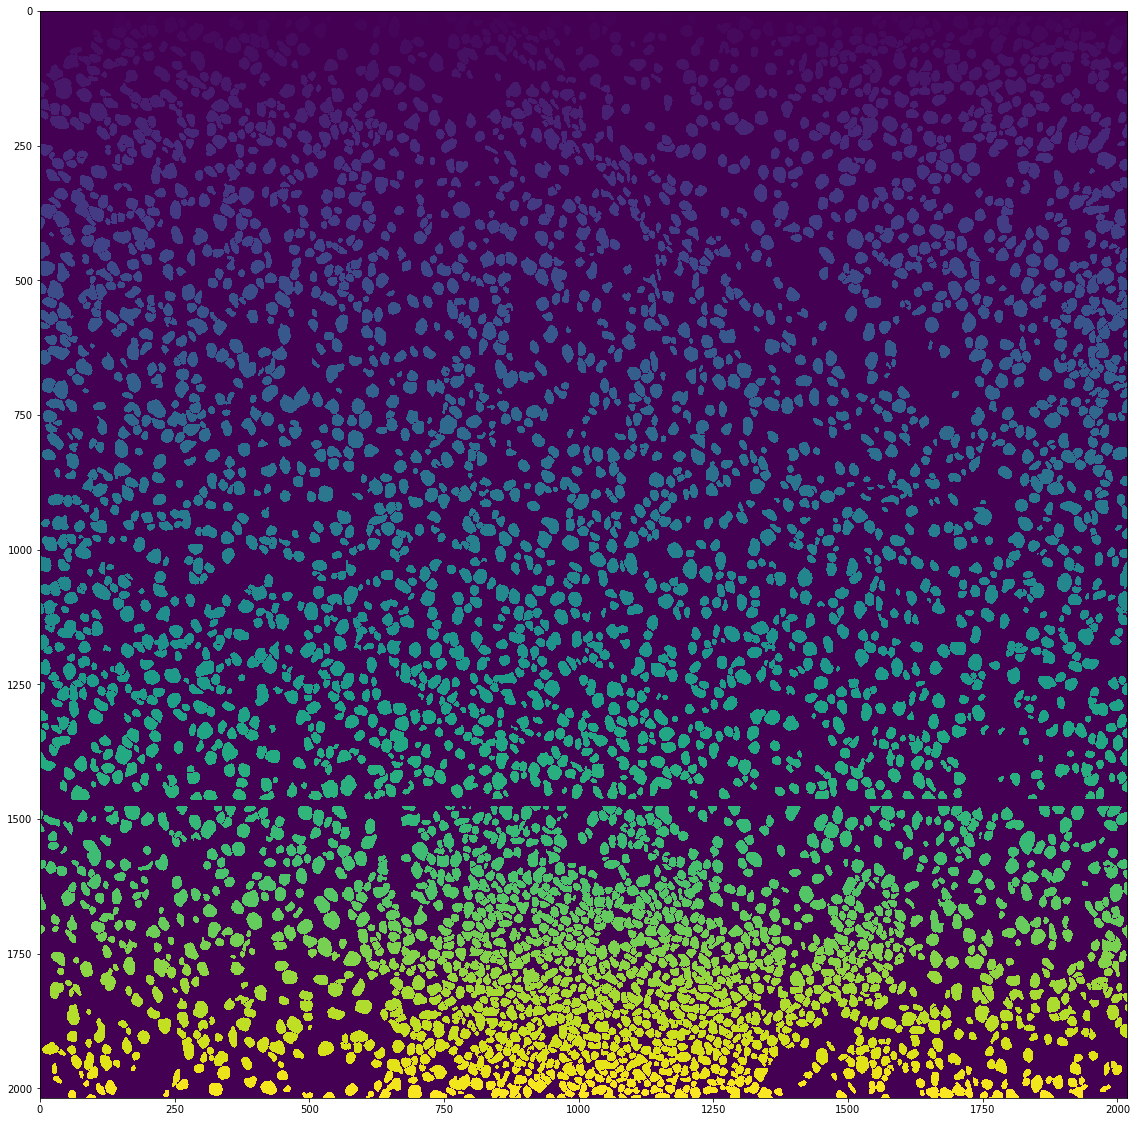

In [22]:
plt.imshow(np.squeeze(watershed_segmentation))